In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

%matplotlib inline

This weather data was collected from weather station which contains three months data for each minute in a day from 6am to 12 pm. Dataset contains:
- **date_time**: IST date and time
- **irradiation**: Solar ratiation value (watt per square meter)
- **ambient_temp**: Ambient temperature for each minute
- **wind_speed**: Speed of wind for each minute

Target: 
    Prediction of future solar irradiance values (W/m^2)

Performance Metrics: 
    r2, RMSE, Normalized RMSE

In [2]:
weather = pd.read_csv('../weather_data_from_plant.csv', index_col=['date_time'], parse_dates=['date_time'])
weather['month'] = weather.index.month
weather['day'] = weather.index.day
weather['minute'] = weather.index.minute
weather.head()

,ambient_temp,wind_speed,irradiance,month,day,minute
date_time,,,,,,
2020-08-21 06:26:01+00:00,28.185780,0.28164,0.000000,8,21,26
2020-08-21 06:27:01+00:00,28.185780,0.28164,0.000000,8,21,27
2020-08-21 06:28:01+00:00,28.185780,0.28164,0.000000,8,21,28
2020-08-21 06:29:01+00:00,28.185780,0.28164,0.000000,8,21,29
2020-08-21 06:30:01+00:00,28.170719,0.28164,3.442247,8,21,30


In [3]:
weather.tail()

,ambient_temp,wind_speed,irradiance,month,day,minute
date_time,,,,,,
2020-10-20 12:57:01+00:00,36.253342,0.28164,749.843811,10,20,57
2020-10-20 12:58:01+00:00,36.238201,1.88136,753.283386,10,20,58
2020-10-20 12:59:01+00:00,36.088779,0.28164,753.283386,10,20,59
2020-10-20 13:00:01+00:00,35.983109,0.28164,753.283386,10,20,0
2020-10-20 13:01:01+00:00,35.952770,0.28164,749.843811,10,20,1


In [4]:
# Select data at interval of 15 minutes
# weather = weather[weather.minute % 5 == 0].copy(deep=True)
weather = weather[weather.minute % 15 == 0].copy(deep=True)

In [5]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5329 entries, 2020-08-21 06:30:01+00:00 to 2020-10-20 13:00:01+00:00
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ambient_temp  5329 non-null   float64
 1   wind_speed    5329 non-null   float64
 2   irradiance    5329 non-null   float64
 3   month         5329 non-null   int64  
 4   day           5329 non-null   int64  
 5   minute        5329 non-null   int64  
dtypes: float64(3), int64(3)
memory usage: 291.4 KB


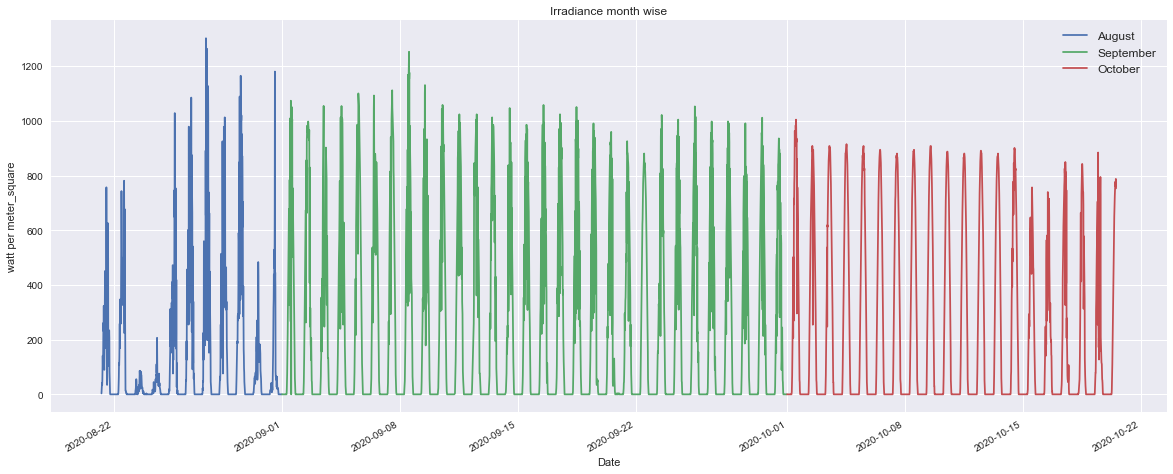

In [6]:
fig, ax = plt.subplots(figsize=(20, 8), sharex=True)
ax = weather.loc['2020-08', 'irradiance'].plot(label='August')
ax = weather.loc['2020-09', 'irradiance'].plot(label='September')
ax = weather.loc['2020-10', 'irradiance'].plot(label='October')
ax.set_title('Irradiance month wise')
ax.set_ylabel('watt per meter_square')
ax.set_xlabel('Date')
plt.legend(fontsize='large')
plt.show()

In above plot, we can see that the `irradiance` shows stationary property over the time i.e. statistical paramters does not change over the time. Also, periodic in nature.

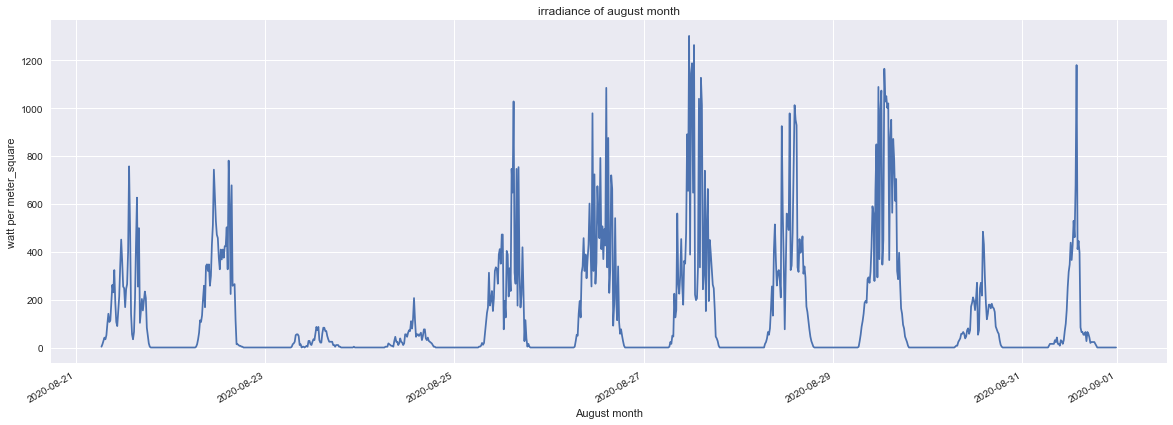

In [7]:
plt.figure(figsize=(20, 7))
ax = weather.loc['2020-08', 'irradiance'].plot()
ax.set_ylabel('watt per meter_square')
ax.set_title('irradiance of august month')
ax.set_xlabel('August month')
plt.show()

It seems that due to cloudy weather some days very low radiations are captured per meter square.

In [8]:
# Correlation Map
corrmap = weather.corr()
corrmap.style.background_gradient(cmap='coolwarm')

,ambient_temp,wind_speed,irradiance,month,day,minute
ambient_temp,1.000000,0.030117,0.644097,0.244715,-0.134084,0.003263
wind_speed,0.030117,1.000000,0.131859,-0.257240,0.194881,0.003200
irradiance,0.644097,0.131859,1.000000,0.100799,-0.101032,0.009739
month,0.244715,-0.257240,0.100799,1.000000,-0.628427,-0.001148
day,-0.134084,0.194881,-0.101032,-0.628427,1.000000,0.006976
minute,0.003263,0.003200,0.009739,-0.001148,0.006976,1.000000


Let's test the data that it is stationary or not using `Dickey fuller` test. Series is stationary means the statistical properties (mean, variance, etc) do not change over the time

In [9]:
from statsmodels.tsa.stattools import adfuller

In [10]:
# H0 = Null hypothesis in ADF test (given time series is non-stationary)
# H1 = Alternate hypothesis in ADF test (given time series in stationary)
# if ADF stat < critical val then reject H0 else accept H0

def is_stationary(series):
    X = series.values
    result = adfuller(X)
    print('ADF statistic: %f' %result[0])
    print('p value: %f' %result[1]) # result[2] is Number of Lags and result[3] number of observations used
    print('Critical Values:')

    for key, val in result[4].items():
        print('\t%s: %.3f' %(key, val))

    if result[0] < result[4]["5%"]:
        print('Reject H0 - Time series is Stationary')
    else:
        print('Accept H0 - Time series is Non-Stationary')

In [11]:
is_stationary(weather['ambient_temp'])

ADF statistic: -14.679453
p value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Reject H0 - Time series is Stationary


In [12]:
is_stationary(weather['irradiance'])

ADF statistic: -16.565200
p value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Reject H0 - Time series is Stationary


# Model

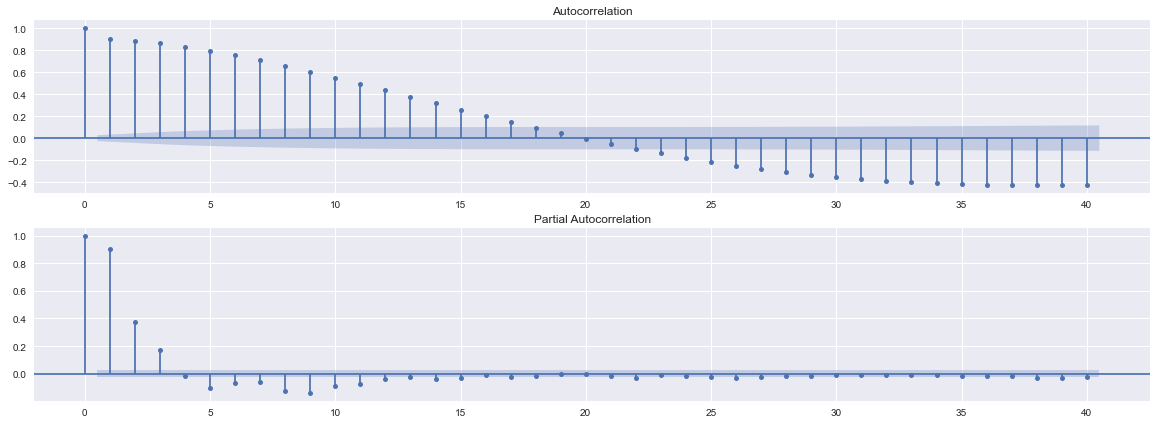

In [13]:
# plot autocorrelation and partial autocorrelation
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

fig = plt.figure(figsize=(20,7))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(weather['irradiance'], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(weather['irradiance'], lags=40, ax=ax2)

In [14]:
# This auto_arima is used to find the p, d and q value for ARIMA model.
from pmdarima import auto_arima

stepwise_fit = auto_arima(weather['irradiance'], trace=True, suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=66061.543, Time=4.44 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=76324.342, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=67376.767, Time=0.21 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=72522.029, Time=1.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=78397.401, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=66417.836, Time=2.18 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=66449.474, Time=2.20 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=66063.191, Time=5.80 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=66064.851, Time=5.33 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=66494.751, Time=1.69 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=66344.165, Time=2.22 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=66406.106, Time=1.25 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=5.91 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=66185.304, Time=1.01 sec

Best model:  ARIMA(2,0,2

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 5329
Model:               SARIMAX(2, 0, 2)   Log Likelihood              -33024.771
Date:                Mon, 28 Dec 2020   AIC                          66061.543
Time:                        20:02:22   BIC                          66101.028
Sample:                             0   HQIC                         66075.337
                               - 5329                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.8017      0.352      5.113      0.000       1.111       2.492
ar.L1          1.9421      0.010    201.411      0.000       1.923       1.961
ar.L2         -0.9505      0.009   -101.345      0.000      -0.969      -0.932
ma.L1         -1.4985      0.011   -136.123      0.000      -1.520      -1.477
ma.L2          0.5653      0.007     81.671      0.000       0.552       0.579
sigma2      1.413e+04    152.333     92.751      0.000    1.38e+04    1.44e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.29   Jarque-Bera (JB):             21988.51
Prob(Q):                              0.59   Prob(JB):                         0.00
Heteroskedasticity (H):               0.17   Skew:                            -0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [15]:
# Split the data into training and testing
print('Total data shape: %d' %weather.shape[0])

training_size = int(len(weather)*0.7)
train = weather.iloc[:training_size]
test = weather.iloc[training_size+1:]

print('Train Shape: %d' %train.shape[0])
print('Test Shape: %d' %test.shape[0])

Total data shape: 5329
Train Shape: 3730
Test Shape: 1598


In [16]:
def norm(x):
    return (x - np.mean(train)) / np.std(train)

normed_train = norm(train)
normed_test = norm(test)

In [17]:
from sklearn.metrics import r2_score, mean_squared_error
from skimage.metrics import normalized_root_mse

def model_performance_metrics(pred, actual):
    '''
    Takes the predicted and actual values and return r2_score, rmse, and normalized rmse
    '''
    #r2_score
    r2 = r2_score(actual, pred)  # 1-(SSR/SST) where SST-sum of square of deviation and SSR-sum of square of error
    #root mean squared error
    rmse = np.sqrt(mean_squared_error(actual, pred))
    #normalized root mean squared error
    nrmse = normalized_root_mse(actual, pred)

    print('R2 score: %f' %r2)
    print('RMSE: %f' %rmse)
    print('Normalized RMSE: %f' %nrmse)

    return r2, rmse, nrmse

## ARIMA Model

In [18]:
# for using ARIMA model we need the data to be stationary
from statsmodels.tsa.arima_model import ARIMA

import warnings
warnings.filterwarnings("ignore")

In [19]:
model=ARIMA(normed_train['irradiance'], order=(2,0,2))
model=model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             irradiance   No. Observations:                 3730
Model:                     ARMA(2, 2)   Log Likelihood               -2230.295
Method:                       css-mle   S.D. of innovations              0.440
Date:                Mon, 28 Dec 2020   AIC                           4472.590
Time:                        20:02:23   BIC                           4509.935
Sample:                             0   HQIC                          4485.875
                                                                              
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0024      0.048     -0.050      0.961      -0.097       0.092
ar.L1.irradiance     1.9389      0.012    156.491      0.000       1.915       1.963
ar.L2.irradiance    -0.9476      0.012    -81.262      0.000      -0.970      -0.925
ma.L1.irradiance    -1.5307      0.015   -101.531      0.000      -1.560      -1.501
ma.L2.irradiance     0.5891      0.015     40.437      0.000       0.561       0.618
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0231           -0.0930j            1.0273           -0.0144
AR.2            1.0231           +0.0930j            1.0273            0.0144
MA.1            1.2993           -0.0971j            1.3029           -0.0119
MA.2            1.2993           +0.0971j            1.3029            0.0119
-----------------------------------------------------------------------------
"""

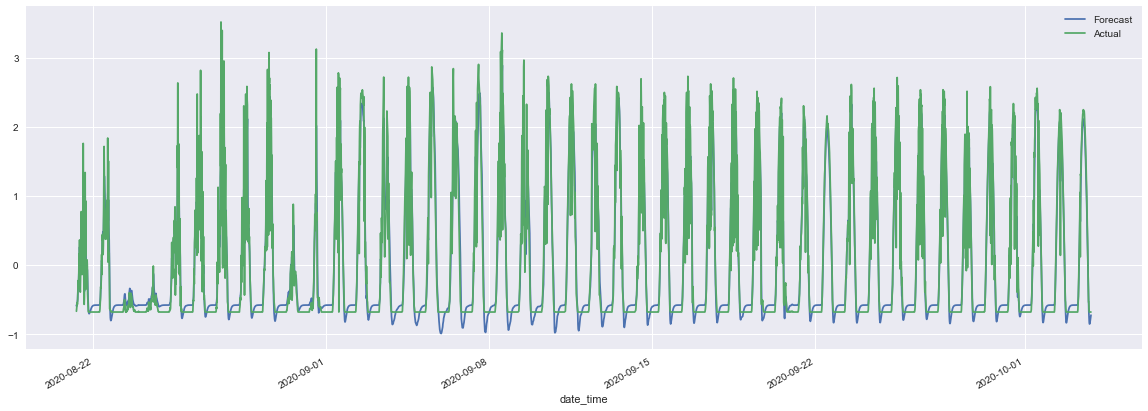

In [20]:
forecast = model.predict(start=1, end=3730, dynamic=False)
forecast.index = normed_train.index

plt.figure(figsize=(20, 7))
forecast.plot(legend=True, label='Forecast')
normed_train['irradiance'].plot(legend=True, label='Actual')
plt.show()

In [21]:
# performance on training set
model_performance_metrics(forecast, normed_train['irradiance'])

R2 score: 0.928238
RMSE: 0.267885
Normalized RMSE: 0.267885


(0.9282375520954509, 0.2678851393872916, 0.2678851393872926)

In [22]:
start = len(normed_train)
end = len(weather)
pred = model.predict(start=start, end=end-2, dynamic=False)
# performance on test set
model_performance_metrics(pred, normed_test['irradiance'])

R2 score: -0.007794
RMSE: 1.020532
Normalized RMSE: 1.002583


(-0.007793863115890698, 1.0205318475589933, 1.002582842097089)

After seeing the above we can say that our model gets overfitted because it performs good on training set and bad prediction on test set.

## SARIMAX model

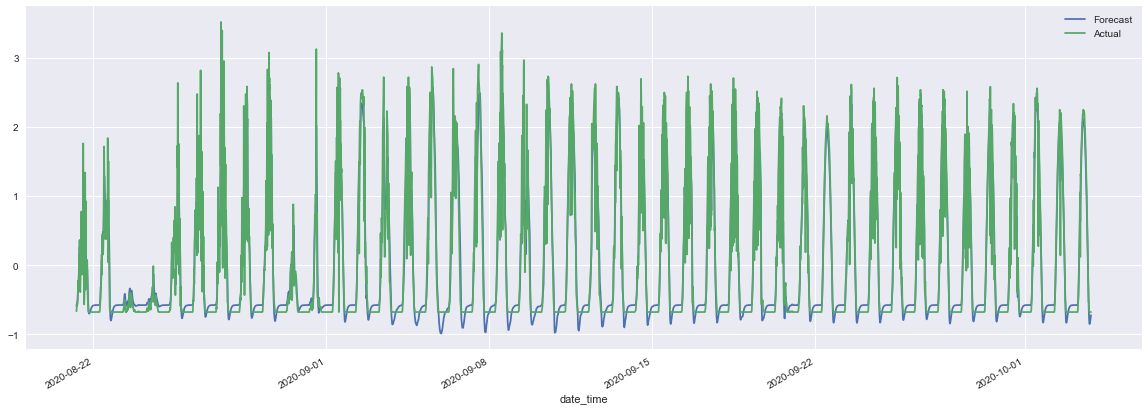

In [23]:
model=sm.tsa.statespace.SARIMAX(normed_train['irradiance'], order=(2, 0, 2), seasonal_order=(0, 0, 0, 0))
model=model.fit()

forecast = model.predict(start=1, end=3730, dynamic=False)
forecast.index = normed_train.index

plt.figure(figsize=(20, 7))
forecast.plot(legend=True, label='Forecast')
normed_train['irradiance'].plot(legend=True, label='Actual')
plt.show()

In [24]:
# performance on training set
model_performance_metrics(forecast, normed_train['irradiance'])

R2 score: 0.928238
RMSE: 0.267885
Normalized RMSE: 0.267885


(0.928237607570955, 0.2678850358438195, 0.2678850358438205)

In [25]:
start = len(normed_train)
end = len(weather)
pred = model.predict(start=start, end=end-2, dynamic=False)
# performance on test set
model_performance_metrics(pred, normed_test['irradiance'])

R2 score: -0.007579
RMSE: 1.020423
Normalized RMSE: 1.002476


(-0.0075786236152346476, 1.0204228617321462, 1.002475773101359)

In this case too our model performs bad on unseen data let's make the prediction using LSTM.

## LSTM model

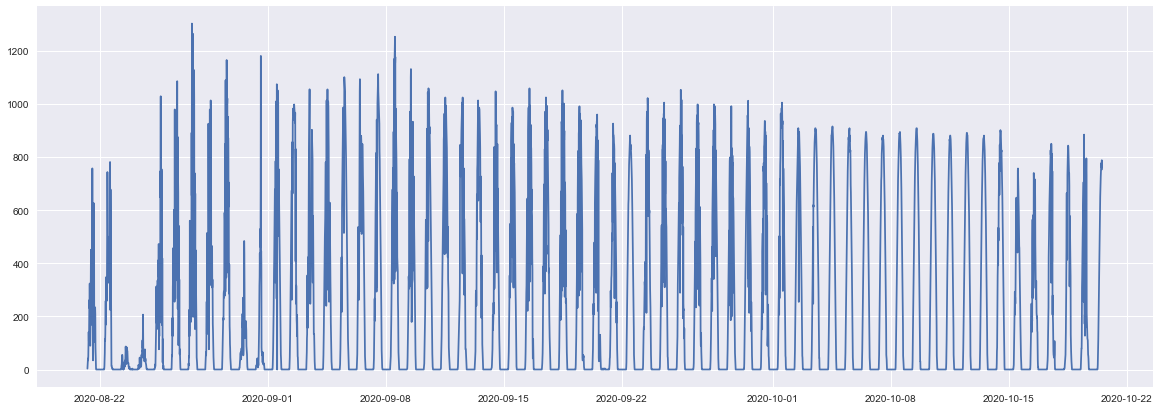

In [26]:
dataset = weather[weather.minute % 15 == 0]['irradiance'].copy(deep=True)
plt.figure(figsize=(20, 7))
plt.title('Irradiance at 15 minutes interval')
plt.plot(dataset)
plt.show()

In [27]:
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [28]:
dataset = dataset.values.reshape(-1, 1)
# normalize the dataset
scaler = MinMaxScaler()
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

3730 1599


In [29]:
# convert an array of value into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [30]:
# reshape into X=t and Y=t+1
look_back = 48
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [31]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back))) # input: [time_steps, features]
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=8, verbose=1)

Epoch 1/100
461/461 [==============================] - 0s 742us/step - loss: 0.0229
Epoch 2/100
461/461 [==============================] - 0s 794us/step - loss: 0.0126
Epoch 3/100
461/461 [==============================] - 0s 764us/step - loss: 0.0113
Epoch 4/100
461/461 [==============================] - 0s 720us/step - loss: 0.0107
Epoch 5/100
461/461 [==============================] - 0s 718us/step - loss: 0.0105
Epoch 6/100
461/461 [==============================] - 0s 725us/step - loss: 0.0103
Epoch 7/100
461/461 [==============================] - 0s 716us/step - loss: 0.0101
Epoch 8/100
461/461 [==============================] - 0s 818us/step - loss: 0.0101
Epoch 9/100
461/461 [==============================] - 0s 746us/step - loss: 0.0100
Epoch 10/100
461/461 [==============================] - 0s 718us/step - loss: 0.0099
Epoch 11/100
461/461 [==============================] - 0s 714us/step - loss: 0.0099
Epoch 12/100
461/461 [==============================] - 0s 753us/step - lo

In [32]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

print('Training score:')
model_performance_metrics(trainY[0], trainPredict[:, 0])
print('\nTest score:')
model_performance_metrics(testY[0], testPredict[:, 0])

Training score:
R2 score: 0.819077
RMSE: 120.536317
Normalized RMSE: 0.342176

Test score:
R2 score: 0.960555
RMSE: 59.147046
Normalized RMSE: 0.158742


(0.9605547739339007, 59.14704553718727, 0.1587422500682778)

We can see that LSTM is performing very good on the unseen data, we can use this model for the future predictions.

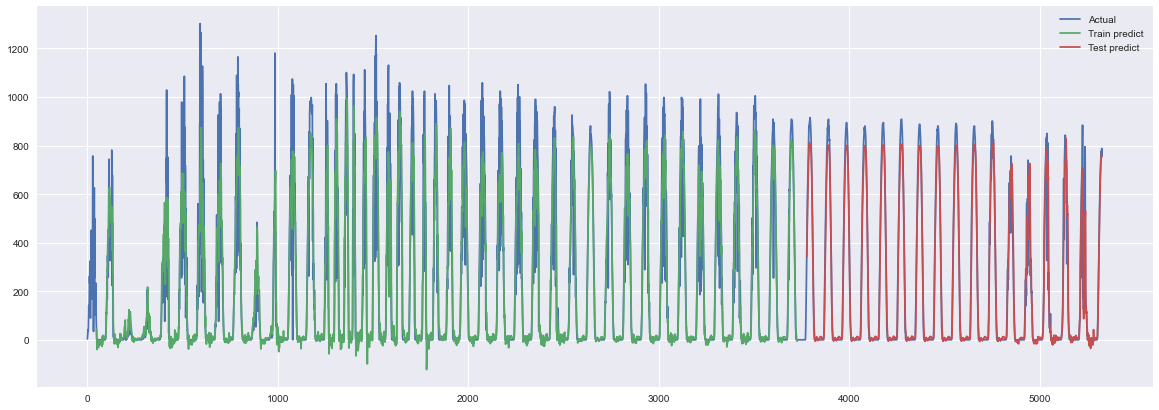

In [33]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(20, 7))
plt.plot(scaler.inverse_transform(dataset), label='Actual')
plt.plot(trainPredictPlot, label='Train predict')
plt.plot(testPredictPlot, label='Test predict')
plt.legend()
plt.show()

From above performance we can see that LSTM is performing well. So, LSTM model can be used for the forcast.